202311_jedha_bloc3_ChallengeML
Beraud Mélanie

www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !


# Import libraries

In [2]:
import pandas as pd
import numpy as np

# Preprocessing
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline

# Model - base estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Model - Ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Model - Scoring
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.tree import plot_tree


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


from plotly.subplots import make_subplots
# Ma palette pour les plotly
pio.templates["mel_purple"] = go.layout.Template(
    layout_colorway=['#FF34B3', '#CD2990', '#8B1C62', '#CD00CD', '#8B008B', '#8968CD', '#5D478B','#20B2AA']) #'#EEA2AD', trop proche

pio.templates.default = "mel_purple"
pio.renderers.default = 'notebook_connected' # to be replaced by "iframe_connected" to have the pictures in files

from IPython.display import display

# Functions

In [3]:
# Preprocessing function:
def prepare_datasets(donnees, name_dataset):

    ''' 
    Should be given:
    * data to process
    * name for the dataset in ''
    The function will prepare Features X/Target Y datatsets, train/val subsets: Splitting and Preprocessing
    And return (in that order):
        * 4 preprocessed datasets (X_train, X_val, y_train, y_val) 
        * list of names for num features, cat features from input dataset
        * name of X_train/X_val columns
        * the name of the dataset for log
    '''
    name_dataset = name_dataset

    X = donnees.drop('converted', axis = 1)
    Y = donnees.loc[:, 'converted']
    print(type(X), X.shape, type(Y), Y.shape)

    # Train_val split
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
    #X_train[0:5], y_val[0:5]

    # Recovery features category_name
    num_features = []
    cat_features = []

    for col in X_train:
        if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64':
            num_features.append(col)
        else:
            cat_features.append(col)

    num_features = num_features
    print(f'num_features are:{num_features},\ncat_features are:{cat_features}')

    # Preprocessings
    norm = StandardScaler()
    encod = OneHotEncoder(drop="first")

    preprocesseur = ColumnTransformer(transformers=[
    ('num', norm, num_features),
    ('cat', encod, cat_features)])
    
    X_train = preprocesseur.fit_transform(X_train)
    X_val = preprocesseur.transform(X_val)

    # recovery of columns names in X_train and X_val
    liste_features_name = []    
    for name in preprocesseur.get_feature_names_out():
        liste_features_name.append(name[5:])
    #print(liste_features_name, liste_features_name[0], liste_features_name[1])

    print (f'Dataset {name_dataset} is ready.')

    return X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset # useless, preprocesseur
    #X_train[0:5], y_train[0:5], X_val[0:5], y_val[0:5], y_train.value_counts(), y_val.value_counts()

# PROBLEM.... I do not return my encod and norm... -> I cannot do an inverse transform to check data ...
# X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full')

def model_scores(name_model, model, name_dataset):
    
    ''' 
    Should be given:
    * name you want to give your model as name_model in ''
    * name of the model as a variable_should be gridsearch_Best_estimators_ if gridsearch
    * name of the dataset. You can use name_dataset from the preprocessing

    The function will return in a dataframe:
    * the accuracy for train and val, 
    * the prediction, 
    * the f1 score for train and val,
    * the full parameters of the classifier
    * the coefficients, 
    * the confusion matix, 
    * the classification report 
    and put everything in a dataframe that can be called.

    It will also display a few intersting tables...
    '''

    name_model = name_model
    name_dataset = name_dataset
    model = model

    # Predictions

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    #scores
    accuracy_train = model.score(X_train, y_train)
    accuracy_val = model.score(X_val, y_val)

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)


    parametres = model.get_params()
    try:
        coefficients = [coef for coef in model.coef_]
    except:
        coefficients =[]
        
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_val, y_val_pred)

    print('classification report train')
    print(report_train)
    print('classification report val')
    print(report_val)

    # Confusion matrix
    tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
    fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

    tn_train, fp_train = confusion_matrix(y_train, y_train_pred)[0,0], confusion_matrix(y_train, y_train_pred)[0,1]
    fn_train, tp_train = confusion_matrix(y_train, y_train_pred)[1,0], confusion_matrix(y_train, y_train_pred)[1,1]
    
    #tn_val, fp_val, fn_val, tp_val

    #Confusion matrix    
    print('matrices de confusion')
    fig_train , ax1 = plt.subplots()
    ax1.set(title="Confusion Matrix on Train set") 
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax1) 
    fig_train.show('notebook_connected')

    fig_val , ax2 = plt.subplots()
    ax2.set(title="Confusion Matrix on val set") 
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, ax=ax2) 
    fig_val.show() 

    report = [name_model, model, name_dataset,  parametres, 
              accuracy_train, accuracy_val, coefficients, 
              y_train_pred, y_val_pred, f1_train, f1_val, 
              tn_val, fp_val, fn_val, tp_val,
              tn_train, fp_train, fn_train, tp_train,
              report_train, report_val]

    

    dataf  = pd.DataFrame(data=[], columns = ['name_model', 'model', 'name_dataset',  'parametres', 
              'accuracy_train', 'accuracy_val', 'coefficients', 
              'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 
              'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train',
              'report_train', 'report_val'])
    

      
    
    dataf.loc[len(dataf), :] = report

    '''
    # model.get_params().__getitem__('C')

    coeff= pd.DataFrame(test['coefficients'][0])
    coeff
    '''
    # presentation
    liste_scores = ['name_model', 'model', 'name_dataset', 'accuracy_train', 'accuracy_val', 'f1_train', 'f1_val']
    liste_confusionMatrix = ['name_model', 'model', 'name_dataset', 'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train']
    liste_params = ['name_model', 'model', 'name_dataset',  'parametres', 'coefficients']

 
    scores = dataf.loc[:, liste_scores]
    confusion = dataf.loc[:, liste_confusionMatrix]
    parametre = dataf.loc[:, liste_params]
    # adapter les parametre selon le type de modèle... et les coeff selon le nb de coeff


    display(scores, confusion, parametre)
    print(f'This function returns a Reporting DataFrame composed of:\n   {[col for col in dataf.columns]}')

    
    return dataf
#resultats_df = model_scores('name_model', model, name_dataset)

def nom_variable(str):
    return str

def feature_eng(x):
    #fonction pour faire du feature_engineering... Retourne 7 valeurs par variables numérique.
    return x**2, np.sqrt(x), 1/x, math.exp(x), math.log10(x), math.log1p(x), math.cos(x)
#len(feature_eng(2))


# Import data

In [141]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)


# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

final_scoring = pd.read_csv('final_scoring.csv')
final_scoring

Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB


name_model  \
0                  reglog_full   
1               reglog_country   
2                   reglog_age   
3              reglog_new_user   
4                reglog_source   
5   reglog_total_pages_visited   
6             reglog_converted   
7                    reglog_gs   
8                reglog_ada_gs   
9                  bag_tree_gs   
10                 bag_tree_gs   
11              tree_simple_gs   
12           tree_simple_gini3   
13           tree_simple_gini8   
14           tree_simple_gs_3f   
15                 svc_1000_3f   
16                svc_10000_3f   
17             svc_gs_3f_10000   
18                 svc_full_3f   
19               xg_gs_full_3f   
20             ada_gs_10000_3f   
21             xg_gs2_10000_3f   
22        reglog_10000feat_eng   
23         tree_10000_feat_eng   
24   bag_tree_1000_feat_eng_gs   
25              reglog_4f_eng2   
26               reglog_4f_eng   
27                 tree_4feng1   
28                 tree_4feng2   
29                   reglog_4f   
30                     tree_4f   

                                                model         name_dataset  \
0                                LogisticRegression()                 full   
1                                LogisticRegression()              country   
2                                LogisticRegression()                  age   
3                                LogisticRegression()             new_user   
4                                LogisticRegression()               source   
5                                LogisticRegression()  total_pages_visited   
6                                LogisticRegression()            converted   
7                           LogisticRegression(C=0.1)                 full   
8   AdaBoostClassifier(estimator=LogisticRegressio...                 full   
9   BaggingClassifier(estimator=DecisionTreeClassi...                 full   
10  BaggingClassifier(estimator=DecisionTreeClassi...                 full   
11  DecisionTreeClassifier(criterion='entropy', ma...                 full   
12                DecisionTreeClassifier(max_depth=3)                 full   
13                DecisionTreeClassifier(max_depth=8)                 full   
14  DecisionTreeClassifier(max_depth=5, min_sample...                3feat   
15                              SVC(probability=True)              1000_3f   
16                              SVC(probability=True)             10000_3f   
17  SVC(C=0.1, gamma=0.1, kernel='linear', probabi...             10000_3f   
18  SVC(C=0.1, gamma=0.1, kernel='linear', probabi...              full_3f   
19  XGBClassifier(base_score=None, booster=None, c...              full_3f   
20  AdaBoostClassifier(estimator=DecisionTreeClass...             10000_3f   
21  XGBClassifier(base_score=None, booster=None, c...                10000   
22                               LogisticRegression()       10000_feat_eng   
23                           DecisionTreeClassifier()       10000_feat_eng   
24  BaggingClassifier(estimator=DecisionTreeClassi...       10000_feat_eng   
25                               LogisticRegression()              4f_eng2   
26                               LogisticRegression()               4f_eng   
27                           DecisionTreeClassifier()              4f_eng2   
28                           DecisionTreeClassifier()              4f_eng2   
29                               LogisticRegression()                   4f   
30                           DecisionTreeClassifier()                   4f   

                                           parametres  accuracy_train  \
0   {'C': 1.0, 'class_weight': None, 'dual': False...        0.986331   
1   {'C': 1.0, 'class_weight': None, 'dual': False...        0.986331   
2   {'C': 1.0, 'class_weight': None, 'dual': False...        0.986331   
3   {'C': 1.0, 'class_weight': None, 'dual': False...        0.986331   
4   {'C': 1.0, 'class_weight': None, 'dual': False...        0.986331

In [140]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False) 

In [84]:
data.head()

'''
data.columns
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

"\ndata.columns\nIndex(['country', 'age', 'new_user', 'source', 'total_pages_visited',\n       'converted'],\n      dtype='object')\n"

In [ ]:
data.describe(include = 'all')

In [ ]:
# No need anymore ...

data.info() # No Null values
data.new_user.astype('category')
data.info()

for col in data.columns:
    print(col, data[col].value_counts(dropna=False))

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

# EDA

In [87]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample.new_user = data_sample.new_user.astype('category')
data_sample.dtypes

#TO WORK without importing dataset
data_sample.to_csv('data_sample.csv') 

In [88]:
data_sample.new_user.value_counts(dropna=False)

new_user
1    6844
0    3156
Name: count, dtype: int64

In [ ]:
data_sample = pd.read_csv('data_sample.csv', index_col=0)
data_sample.new_user = data.new_user.astype('category')

'''
Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')
'''

data_sample.info()

# recovery of num features and cat features
num_features = []
cat_features = []

for col in data_sample:
    if data_sample[col].dtypes == 'int64' or data_sample[col].dtypes == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

num_features = num_features[:-1]
num_features, cat_features

In [ ]:
data_sample.new_user.value_counts(dropna=False)

In [ ]:
# Pairwise dependencies _ no need here
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height = 1200, width = 1200)
fig.show()

In [ ]:
data_sample.describe(include='all')

In [ ]:
data_sample.new_user.value_counts(dropna=False)


In [ ]:

''' Nope... sert à en mettre plusieurs à côté
fig, ax = plt.subplots(1,2, figsize=(20, 10))
for axi in ax.flatten():  # enumerate - 0 pour histogramme et 1 box
    axi.hist(data_sample[col])
'''

for col in num_features:
    fig = make_subplots(rows = 1, cols = 2)#, figsize=[10,20])

    fig.add_trace(px.histogram(data_sample[col]).data[0], row = 1, col=1)
    fig.add_trace(px.box(data_sample[col]).data[0], row = 1, col=2)
    fig.update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
                    showlegend=False, width=800, height =400)
    #fig.show('iframe_connected') #only the last one :()
    display(fig)

   
    # ne fonctionne pas avec fig, axs & ax[0], ou ax[0,0], ne fonctionne pas avec fig, '(ax1, ax2) et ax1= 


for col in cat_features:
    fig = px.histogram(data_sample[col], title=f'Distribution {col}')
    fig.update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
                    showlegend=False, width=800, height =400)
    display(fig)




In [ ]:
data.age.mean(), data.age.max()
fig = px.histogram(data.age)

fig = px.histogram(data.age[data['age']>60])
display(fig)
fig.show('notebook_connected')
# Garder en tête : Il y a des ousiders en age : 110 et 120 ans

### Garder en tête : Il y a des ousiders en age : 110 et 120 ans. Record reconnu de tous les ltemps : Jeanne Calmant 121 ans.

In [96]:
# useless  on only 2 num_features...
temp = data.loc[:,num_features]
corr_matrix = temp.corr().round(2)

corr_matrix


age  total_pages_visited
age                  1.00                -0.05
total_pages_visited -0.05                 1.00

In [ ]:
# doesn't work

'''
import ipywidgets as ipw

VBox([HBox([fw1, fw2]), HBox([fw3])])
'''

fig2 = make_subplots(rows = 1, cols = 3) # doesnt' work

for col in cat_features:
    
    #gra = px.histogram(data_sample[col], title=f'Distribution {col}')
    #fig2.get_subplot(row = 1, col = 1, subplots = gra)
    #fig2 =  ipw.HBox([gra])                  
    fig2.add_traces(px.histogram(data_sample[col]), rows = 0, cols =1)#, title=f'Distribution {col}')
    #update_layout(title=f'Distribution {col}', font=dict(size=20), title_font_color="#8B1C62", 
#                    showlegend=False, width=800, height =400)
fig2.show()

### Preprocessing before separation :
No NaN, encoding cat = ok
### Preprocessing after separation:
OneHotEncoder for 3 cat, norm for 2 num

# First model

In [ ]:
print(X_train.age[0:5], X_val.age[0:5], X_train.columns, X_val.columns)

 X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)

# Preprocessings
norm = StandardScaler()
encod = OneHotEncoder(drop="first")

preprocesseur = ColumnTransformer(transformers=[
('num', norm, num_features),
('cat', encod, cat_features)])

X_train = preprocesseur.fit_transform(X_train)
X_val = preprocesseur.transform(X_val)

print(X_train[0:5], X_val[0:5]) # ok

In [ ]:

corr_matrix = X.corr().round(2) # doesn't work
#import plotly.figure_factory as ff
'''
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()
temp = corr(data)
'''
corr_matrix


In [ ]:
liste_features_name = []
'''
array(['num__age', 'num__total_pages_visited', 'cat__country_China',
       'cat__country_Germany', 'cat__country_UK', 'cat__country_US',
       'cat__new_user_0', 'cat__new_user_1', 'cat__source_Ads',
       'cat__source_Direct', 'cat__source_Seo'], dtype=object)
'''
for name in preprocesseur.get_feature_names_out():
       liste_features_name.append(name[5:])

liste_features_name, liste_features_name[0], liste_features_name[1]


(['age',
  'total_pages_visited',
  'country_Germany',
  'country_UK',
  'country_US',
  'new_user_1',
  'source_Direct',
  'source_Seo'],
 'age',
 'total_pages_visited')

In [ ]:
train_sample = pd.DataFrame(X_train[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
val_sample = pd.DataFrame(X_val[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
#val_sample.head()

print(train_sample.shape, val_sample.shape)


fig = make_subplots(rows = 1, cols = 4)#, figsize=[10,20])

fig.add_trace(px.histogram(train_sample[liste_features_name[0]]).data[0], row = 1, col=1)
fig.add_trace(px.histogram(train_sample[liste_features_name[1]]).data[0], row = 1, col=2)
fig.add_trace(px.histogram(val_sample[liste_features_name[0]]).data[0], row = 1, col=3)
fig.add_trace(px.histogram(val_sample[liste_features_name[1]]).data[0], row = 1, col=4)
fig.update_layout(showlegend=False, width=1200, height =400)


display(fig)


Prendre les attributs 1 à 1 ne hange rien

## Training pipeline

# For feature engineering : avec dataset 3f_eng

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

X_train accuracy:0.98925,
X_val accuracy:0.99

X_train F1:0.8,
X_val F1:0.8113207547169811
Features_importance:


Confusion Matrix:


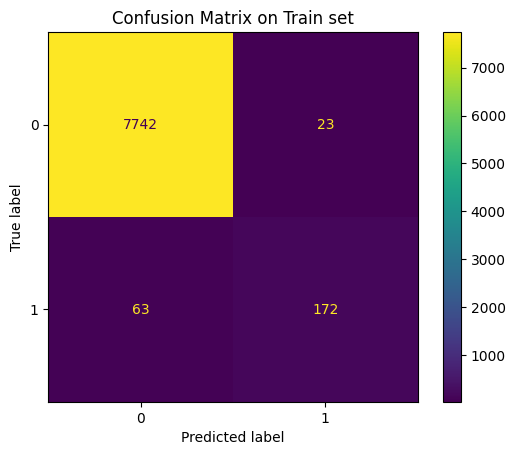

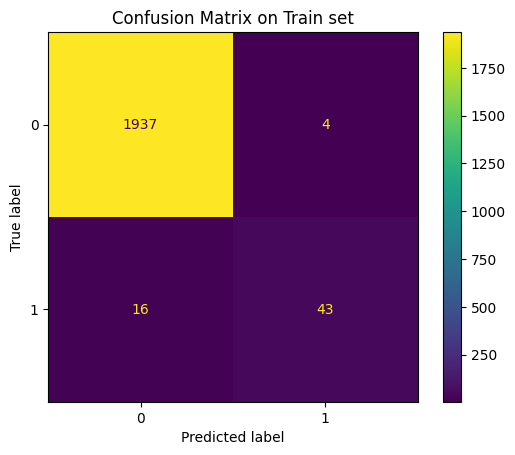

In [55]:
# First model

classifier = LogisticRegression() # 
classifier.fit(X_train, y_train)

list_params = classifier.get_params()
print(list_params)

classifier.score(X_train, y_train)
print(f"\nX_train accuracy:{classifier.score(X_train, y_train)},\n\
X_val accuracy:{classifier.score(X_val, y_val)}\n")

# Predictions & F1
y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

print(f'X_train F1:{f1_score(y_train, y_train_pred)},\n\
X_val F1:{f1_score(y_val,y_val_pred)}')

# coeff importance:
print('Features_importance:')
feat_imp = pd.DataFrame([coef for coef in classifier.coef_], columns=liste_features_name)
feat_imp

temp = feat_imp.transpose()
fig = px.bar(temp, x = abs(temp[0]), orientation='h', color=temp[0])
fig.update_layout(showlegend=False, title=f'Feature importance', font=dict(size=15), title_font_color="#8B1C62", margin=dict(l=150, r=20, t=50, b=40))
fig.update_yaxes(title = None)
fig.show()

# Confusion matrix

tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

#tn_val, fp_val, fn_val, tp_val

print('Confusion Matrix:')
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_val, y_val, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

#reglog_eng = model_scores('reglog_eng', classifier, 'feat_eng')
#final_scoring= pd.concat([final_scoring,reglog_eng])

# the best so far : 0.8	0.811321

# better avec age_demi. Pour total pages = ça a aidé, on dirait. Il faut y mettre un poids plus important. Donc pourquoi pas prendre le carré de total pages visited et le demi de age demi...
#Pour les pays, seul US, UK et Germany sont cool... quelles sont les valeurs ici ?



### Most important features 
seems to be The number of pages visited (positive correlation) and the country, the new user variable
Impact of sources is not that important, age neither.

### scores
F1 and accracy scores are basically the same for train and test

### Confusion matrice:
30% errors ont the positives labels (30% have been predicted as negative)
15% predicted neg should be true.

We need to work on the 30% errors...
Try with a gradient ?



# Data - Feature engineering

### Datasets - Splitting, Preprocessing

In [149]:
# all columns = 'full'
#data

# 3feat: feature - engineering sans colonnes: 
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'converted']]

#sample 1000
#data = data.sample(1000)

#sample 10000
#data = data.sample(10000)
#print(data.shape)


#feat_eng ------------------------------------
'''
# Feature_eng data['age'] 
data['age_carre'], data['age_sq'], data['age_demi'], \
    data['age_exp'], data['age_log10'], data['age_ln'],\
          data['age_cos'] = data['age'].apply(lambda x: feature_eng(x)[0]), data['age'].apply(lambda x: feature_eng(x)[1]), data['age'].apply(lambda x: feature_eng(x)[2]), \
            data['age'].apply(lambda x: feature_eng(x)[3]), data['age'].apply(lambda x: feature_eng(x)[4]), data['age'].apply(lambda x: feature_eng(x)[5]), \
            data['age'].apply(lambda x: feature_eng(x)[6])

# Feature_eng data['total_pages_visited'] 
data['total_pages_visited_carre'], data['total_pages_visited_sq'], data['total_pages_visited_demi'], \
    data['total_pages_visited_exp'], data['total_pages_visited_log10'], data['total_pages_visited_ln'],\
          data['total_pages_visited_cos'] = data['total_pages_visited'].apply(lambda x: feature_eng(x)[0]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[1]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[2]), \
            data['total_pages_visited'].apply(lambda x: feature_eng(x)[3]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[4]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[5]), \
            data['total_pages_visited'].apply(lambda x: feature_eng(x)[6])

## Trouver un moyen de le faire compréhensif... Pas réussi comme ça, mais ça doit se faire.
# ------------------------------------------------------
'''
##4feat_data_eng
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#data['age_demi'], data['total_pages_visited_carre'] = data['age'].apply(lambda x: feature_eng(x)[2]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[0])
#data = data.drop(['total_pages_visited', 'age'], axis = 1)

##4f_eng2
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x/4), data['total_pages_visited'].apply(lambda y: y/2)
#data = data.drop(['total_pages_visited', 'age'], axis = 1)


#tester avec counrty normaux, total pages normaux ou 1/2 et 1/2 ou 1/4 de age... Pour deonner du poids à country.

##4f - not eng.
data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]





data.head()

X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full') 

#X_train[0:5], type(X_train), len(X_train), y_train[0:5], type(y_train), len(y_train), X_train [0], y_train[0] # attention aux index


<class 'pandas.core.frame.DataFrame'> (284580, 4) <class 'pandas.core.series.Series'> (284580,)
num_features are:['age', 'total_pages_visited'],
cat_features are:['new_user', 'country']
Dataset full is ready.


In [151]:
X_train

array([[-1.3990984 , -1.15935344,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.29299544,  0.03743241,  1.        ,  0.        ,  0.        ,
         1.        ],
       [ 2.46854467, -0.86015697,  1.        ,  0.        ,  0.        ,
         1.        ],
       ...,
       [ 0.05126775, -1.15935344,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.43218763,  1.23421826,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.65558698,  0.9350218 ,  1.        ,  0.        ,  0.        ,
         1.        ]])

In [160]:
##4f_sup/4f_inf

### recreate Dataframe with X and y
temp = pd.DataFrame(X_train, columns=liste_features_name)
temp = temp.reset_index()
temp = temp.drop('index', axis =1)

temp['y'] = y_train.values # je dois rindexer et prendre les valeurs, sinon il prend les valeurs de y et ça déconne
temp.head()

### Keep the indexes to be able to sort afterwards and recover the data in the right order if required for evaluation or for prediction (needs to be well made)
index_inf = [item for item in temp.loc[temp['total_pages_visited'] <= 2.281, : ].index] 
index_sup = [item for item in temp.loc[temp['total_pages_visited'] > 2.281, : ].index] # équivaut à > 13 pages visitées 

len(index_inf), len(index_sup), len(index_inf) + len(index_sup)
# to keep for later


### create 2 datasets according to the norm_total_pages_visited
temp_sup = temp.loc[temp['total_pages_visited'] > 2.281, : ]
temp_sup.reset_index(inplace=True)
temp_sup = temp_sup.drop('index', axis = 1)

temp_inf = temp.loc[temp['total_pages_visited'] <= 2.281, : ]
temp_inf.reset_index(inplace=True)
temp_inf = temp_inf.drop('index', axis = 1)

temp_sup.shape, temp_inf.shape, temp_sup.head()

# il faudra réindexer plus tard....

### recreate set X_train, X_test sets....

X_sup = temp_sup.drop('y', axis = 1)
y_sup = temp_sup.loc[:,'y']

X_inf = temp_inf.drop('y', axis = 1)
y_inf = temp_inf.loc[:,'y']

print(X_sup.shape, len(y_sup), X_inf.shape, len(y_inf))
X_sup.head() #ok


### pour réindexer plus tard, il faudra recréer un dataframe, ajouter la colonne index avec les valeurs que je connais, fusionner sup et inf et trier.... 
#temp_sup_test = temp_sup.reset_index(names=index_test) # ne fonctionne pas
#temp_sup_test.index = temp_sup_test['index']

# Si nécessaire, car peut être que je n'aurais pas besoin daller faire pareil dans le test set...

(7158, 6) 7158 (220506, 6) 220506


age  total_pages_visited  new_user_1  country_Germany  country_UK  \
0 -0.794779             3.328593         1.0              1.0         0.0   
1 -0.915643             3.627790         1.0              0.0         0.0   
2 -1.278235             4.226183         0.0              0.0         1.0   
3 -1.036507             3.926986         0.0              0.0         0.0   
4 -0.553051             4.226183         1.0              0.0         0.0   

   country_US  
0         0.0  
1         1.0  
2         0.0  
3         1.0  
4         1.0

In [162]:
X_train, y_train = X_inf, y_inf
X_train.shape, len(y_train)

((220506, 6), 220506)

In [54]:
#3feat_eng
data_num = data.loc[:, num_features]
corr_matrix = data_num.corr().round(2)
corr_matrix # ça n'a pas changé le monde.

age  total_pages_visited  age_carre  age_sq  \
age                        1.00                -0.04       0.99    1.00   
total_pages_visited       -0.04                 1.00      -0.04   -0.04   
age_carre                  0.99                -0.04       1.00    0.97   
age_sq                     1.00                -0.04       0.97    1.00   
age_demi                  -0.95                 0.04      -0.89   -0.97   
age_exp                    0.05                -0.01       0.07    0.04   
age_log10                  0.99                -0.04       0.95    1.00   
age_ln                     0.99                -0.04       0.95    1.00   
age_cos                   -0.03                 0.00      -0.02   -0.04   
total_pages_visited_carre -0.06                 0.93      -0.05   -0.06   
total_pages_visited_sq    -0.03                 0.98      -0.03   -0.03   
total_pages_visited_demi   0.00                -0.72       0.00    0.00   
total_pages_visited_exp   -0.01                 0.15      -0.01   -0.01   
total_pages_visited_log10 -0.02                 0.91      -0.02   -0.02   
total_pages_visited_ln    -0.02                 0.94      -0.02   -0.02   
total_pages_visited_cos   -0.01                 0.12      -0.01   -0.01   

                           age_demi  age_exp  age_log10  age_ln  age_cos  \
age                           -0.95     0.05       0.99    0.99    -0.03   
total_pages_visited            0.04    -0.01      -0.04   -0.04     0.00   
age_carre                     -0.89     0.07       0.95    0.95    -0.02   
age_sq                        -0.97     0.04       1.00    1.00    -0.04   
age_demi                       1.00    -0.02      -0.99   -0.99     0.06   
age_exp                       -0.02     1.00       0.03    0.03    -0.01   
age_log10                     -0.99     0.03       1.00    1.00    -0.05   
age_ln                        -0.99     0.03       1.00    1.00    -0.05   
age_cos                        0.06    -0.01      -0.05   -0.05     1.00   
total_pages_visited_carre      0.06    -0.00      -0.06   -0.06     0.00   
total_pages_visited_sq         0.03    -0.00      -0.03   -0.03     0.00   
total_pages_visited_demi      -0.00    -0.00       0.00    0.00     0.00   
total_pages_visited_exp        0.01    -0.00      -0.01   -0.01    -0.02   
total_pages_visited_log10      0.02    -0.00      -0.02   -0.02     0.00   
total_pages_visited_ln         0.02    -0.00      -0.02   -0.02     0.00   
total_pages_visited_cos        0.01    -0.01      -0.01   -0.01     0.00   

                           total_pages_visited_carre  total_pages_visited_sq  \
age                                            -0.06                   -0.03   
total_pages_visited                             0.93                    0.98   
age_carre                                      -0.05                   -0.03   
age_sq                                         -0.06                   -0.03   
age_demi                                        0.06                    0.03   
age_exp                                        -0.00                   -0.00   
age_log10                                      -0.06                   -0.03   
age_ln                                         -0.06                   -0.03   
age_cos                                         0.00                    0.00   
total_pages_visited_carre                       1.00                    0.83   
total_pages_visited_sq                          0.83                    1.00   
total_pages_visited_demi                       -0.47                   -0.84   
total_pages_visited_exp                         0.27                    0.10   
total_pages_visited_log10                       0.70                    0.98   
total_pages_visited_ln                          0.75                    0.99   
total_pages_visited_cos                         0.09                    0.09   

                           total_pages_visited_demi  total_pages_visited_exp  \
age               

In [90]:
temp = pd.DataFrame(X_train, columns=liste_features_name)
temp['y'] = y_train # si je passe par un concat, j'ai un soucis d'index
temp.head()


age  total_pages_visited  new_user_1  country_Germany  country_UK  \
0 -1.399098            -1.159353         1.0              0.0         0.0   
1  0.292995             0.037432         1.0              0.0         0.0   
2  2.468545            -0.860157         1.0              0.0         0.0   
3 -1.640826            -1.159353         0.0              0.0         0.0   
4 -0.311324             0.037432         1.0              0.0         0.0   

   country_US    y  
0         0.0  0.0  
1         1.0  0.0  
2         1.0  1.0  
3         0.0  0.0  
4         0.0  0.0

In [114]:
temp_sup_test = temp_sup.reset_index(names=index_test) # ne fonctionne pas
temp_sup_test.index = temp_sup_test['index'] # ok. Donc 1, je créé le 

In [115]:
temp_sup_test

120   index       age  total_pages_visited  new_user_1  \
index                                                             
67         0      67 -0.794779             3.328593         1.0   
72         1      72 -0.915643             3.627790         1.0   
89         2      89 -1.278235             4.226183         0.0   
136        3     136 -1.036507             3.926986         0.0   
160        4     160 -0.553051             4.226183         1.0   
...      ...     ...       ...                  ...         ...   
227470  7153  227470  0.292995             3.029397         1.0   
227607  7154  227607 -1.519962             3.926986         0.0   
227614  7155  227614 -1.157371             4.824576         0.0   
227622  7156  227622 -0.553051             2.730201         1.0   
227659  7157  227659 -0.190460             3.029397         0.0   

        country_Germany  country_UK  country_US    y  
index                                                 
67                  1.0         0.0         0.0  0.0  
72                  0.0         0.0         1.0  0.0  
89                  0.0         1.0         0.0  NaN  
136                 0.0         0.0         1.0  NaN  
160                 0.0         0.0         1.0  0.0  
...                 ...         ...         ...  ...  
227470              0.0         0.0         0.0  NaN  
227607              1.0         0.0         0.0  0.0  
227614              0.0         0.0         1.0  0.0  
227622              0.0         0.0         1.0  0.0  
227659              0.0         0.0         1.0  0.0  

[7158 rows x 9 columns]

age    9563
tpv    9563
dtype: int64

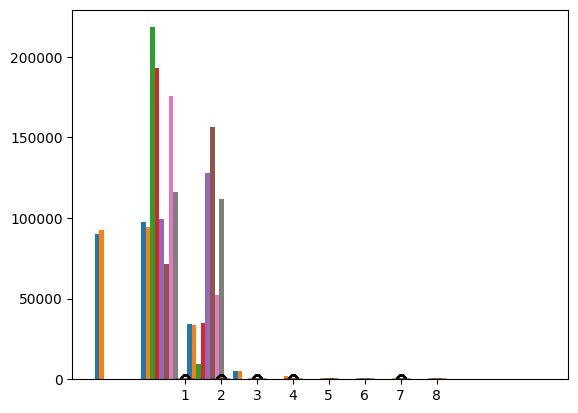

In [73]:
# check features which are badly labelised : e.g. between 1,684 et 2,88 pages_visited...7158 samples on the train set. 

temp = pd.DataFrame(X_train, columns = liste_features_name)
plt.boxplot(temp)# equivaut à total pages visited = colonne [1]
plt.hist(temp)


In [9]:
# Rien aprè 40min
'''
# Take the interesting Features... 40min....
# Define parameter space
eps_values = [0.2, 0.5, 0.8, 1, 1.2, 1.5] # qu'est ce que ça mesure ? epsilon, c'est la densité...
min_samples_values = [50,100,150,200] # c'est le nombre de voisin... j'aurais dû tester avec moins...
metrics = ["cityblock", "euclidean", "manhattan"]
# Grid search
best_score = -1
best_params = {'eps': None, 'min_samples': None, 'metric': None}

for eps in eps_values:
    for min_samples in min_samples_values:
        for metric in metrics:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            db.fit(X_train)
            labels = db.labels_

            # Continue if all data is considered as noise
            if len(set(labels)) == 1:
                continue

            try:
                score = silhouette_score(X_train, labels)
            except:
                print("Not enough labels")
            if score > best_score and len(np.unique(labels)) >=3:
                best_score = score
                best_labels_unique, best_labels_count = np.unique(labels,return_counts=True)
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples
                best_params['metric'] = metric

# Best parameters
print("Best silhouette score:", best_score)
print("Best parameters:", best_params)
print("Unique labels:", best_labels_unique)
print("Count of labels:", best_labels_count)

silhouette_score(X_train, db.labels_)

db = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric=best_params['metric'])
db.fit(X)
labels = db.labels_
''' 

Not enough labels


In [ ]:
# check features avec le plottree
# Perform grid search
decision_tree = DecisionTreeClassifier()

# importer le final scoring
# Grid of values to be tested
params = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth': [4, 5, 8, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}

tree_simple_gs_m = GridSearchCV(decision_tree, param_grid = params, cv = 3)
tree_simple_gs_m .fit(X_train, y_train)

tree_simple_3feat = model_scores('tree_simple_gs_3f', tree_simple_gs_m.best_estimator_, '3feat')

final_scoring= pd.concat([final_scoring,tree_simple_3feat])
#final_scoring.loc[final_scoring['name_model'] == 'tree_simple_gs', 'parametres'].values

# 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

# peut être fait avec DBScan, mais ce serait triché en ML Supervised
# moins bon en 3 feat

In [ ]:
# Gridsearch gave these results : 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,

# check features avec le plottree
#decision_tree_gini = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='gini')
decision_tree_gini = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='gini')
#0.7654 0.7343
#Gini Impurity: It also calculates the purity of the split at nodes of decision tree.
#Gini impurity varies between 0–0.5 .A node is pure when Gini attribute is 0 i.e., all instances are of same class.

decision_tree_ent = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='entropy')
#0.7583 0.7375
#Entropy = 0 means it is pure split i.e., all instances are of only 1 class.
#Entropy=1 means Completely impure split i.e., equal instances (50%–50%) of both class at node causing extreme disorder.


decision_tree_log = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='log_loss')
#0.7583 0.7375


model = decision_tree_gini

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(round(f1_score(y_train, y_train_pred), 4), round(f1_score(y_val, y_val_pred), 4))

tree_gini8_3feat = model_scores('tree_simple_gini8', model, '3feat')

final_scoring= pd.concat([final_scoring,tree_gini8_full])


# 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,
# auss bien que le train sur la reg_log, mais moins bien sur le val. ca reste le meilleur arbre.

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')


'''
plt.figure(figsize=(400,50))
a = plot_tree(model, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(model)
'''
# pas assez avec 5 en max_depth
# keep criterion = gini

Text(0.5, 1.0, 'DecisionTreeClassifier(max_depth=3)')

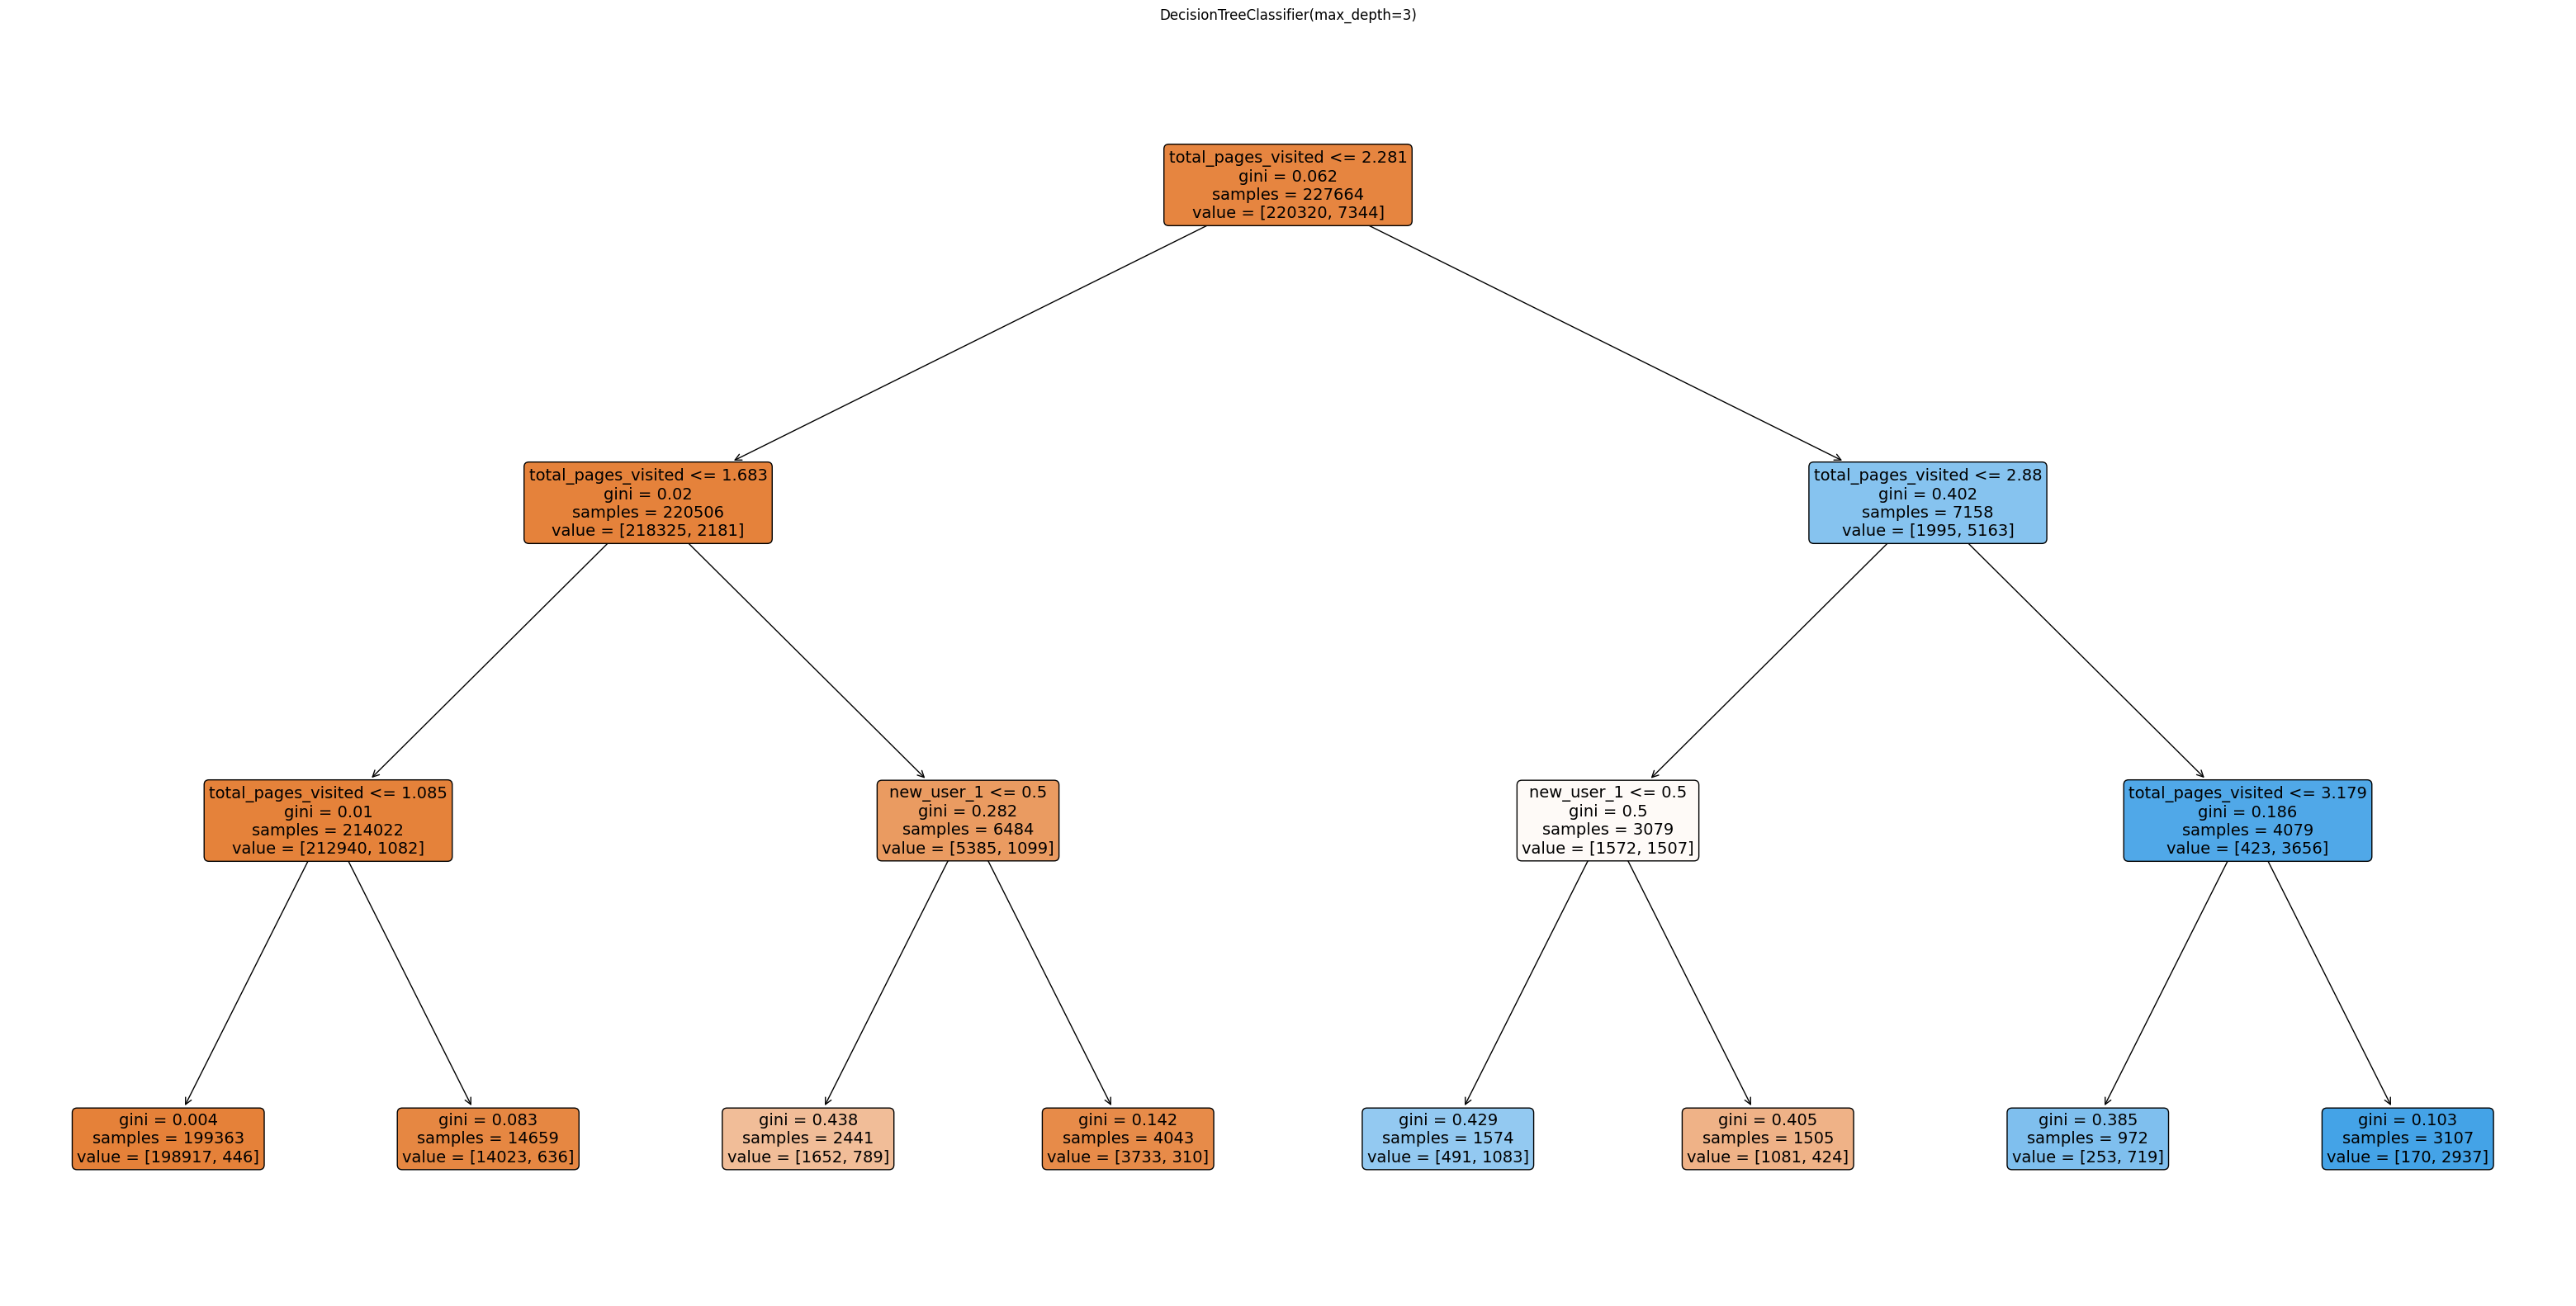

In [28]:
plt.figure(figsize=(40,20))
a = plot_tree(model, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(model)

### Apparemment, seules les variables total_pages_visited et new_user et age
### Comprendre la 1ère séparation, où tout une partie est compliquée à prédire...


In [83]:
### Comprendre la 1ère séparation, où tout une partie est compliquée à prédire...
### Apparemment, seules les cat total_pages_visited et new_user et age


# recupe donrmalisation pour faire le reverse encoding
X1 = data.loc[:,['age', 'total_pages_visited']]
Y2 = data.loc[:, 'converted']
X_train_bis,_ , _ , _ = train_test_split(X1, Y2, test_size=0.2, random_state=0, stratify = Y2)

norm = StandardScaler()
X_train_bis = norm.fit(X_train_bis)

#temp3['pages'] = temp3['tpv'].apply(lambda x: norm.inverse_transform(x))
#temp3
### je veux virer ce qui est > 2, 281

tpv = pd.DataFrame(temp.loc[:,['age', 'total_pages_visited']])
tpv.columns = ['age', 'tpv']

print(tpv[tpv['tpv']>2.281].count(), tpv[tpv['tpv']<=2.281].count(),) #7158, 220508

temp3 = tpv.loc[tpv['tpv']>2.281,:]
print(temp3.count())

temp3.reset_index(inplace = True) 
#temp3# index 0 and co ne fonctionne pas car mes indexe ne vont pas de 0 à x
temp3 = temp3.drop("index", axis = 1)
temp3

temp4 = pd.DataFrame(norm.inverse_transform(temp3), columns=['age', 'total_pages_visited'])
temp4.describe()
# pb avec les gens qui ont visité entre 11 et 14 pages...

#Entre 13 et 27 pages visitées:

age    7158
tpv    7158
dtype: int64 age    220506
tpv    220506
dtype: int64
age    7158
tpv    7158
dtype: int64


age  total_pages_visited
count  7158.000000          7158.000000
mean     27.842693            15.758731
std       7.675267             2.720667
min      17.000000            13.000000
25%      22.000000            14.000000
50%      27.000000            15.000000
75%      33.000000            17.000000
max     123.000000            27.000000

# Models

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

## Regression Logistique

/home/melb/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/home/melb/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    218325
           1       0.63      0.13      0.22      2181

    accuracy                           0.99    220506
   macro avg       0.81      0.56      0.61    220506
weighted avg       0.99      0.99      0.99    220506

classification report val
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.85      0.68      0.75      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.87     56916
weighted avg       0.98      0.99      0.98     56916

matrices de confusion


/tmp/ipykernel_13540/1506233637.py:129: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/home/melb/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/tmp/ipykernel_13540/1506233637.py:134: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



name_model                 model name_dataset accuracy_train  \
0  reglog_4f_inf  LogisticRegression()       4f_inf       0.990631   

  accuracy_val  f1_train    f1_val  
0      0.98561  0.216237  0.752344

name_model                 model name_dataset tn_val fp_val fn_val  \
0  reglog_4f_inf  LogisticRegression()       4f_inf  54853    227    592   

  tp_val tn_train fp_train fn_train tp_train  
0   1244   218155      170     1896      285

name_model                 model name_dataset  \
0  reglog_4f_inf  LogisticRegression()       4f_inf   

                                          parametres  \
0  {'C': 1.0, 'class_weight': None, 'dual': False...   

                                        coefficients  
0  [[-0.5806353542589094, 2.51743053920183, -1.65...

This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val']


name_model  \
0                  reglog_full   
1               reglog_country   
2                   reglog_age   
3              reglog_new_user   
4                reglog_source   
5   reglog_total_pages_visited   
6             reglog_converted   
7                    reglog_gs   
8                reglog_ada_gs   
9                  bag_tree_gs   
10                 bag_tree_gs   
11              tree_simple_gs   
12           tree_simple_gini3   
13           tree_simple_gini8   
14           tree_simple_gs_3f   
15                 svc_1000_3f   
16                svc_10000_3f   
17             svc_gs_3f_10000   
18                 svc_full_3f   
19               xg_gs_full_3f   
20             ada_gs_10000_3f   
21             xg_gs2_10000_3f   
22        reglog_10000feat_eng   
23         tree_10000_feat_eng   
24   bag_tree_1000_feat_eng_gs   
25              reglog_4f_eng2   
26               reglog_4f_eng   
27                 tree_4feng1   
28                 tree_4feng2   
29                   reglog_4f   
30                     tree_4f   
0                reglog_4f_inf   

                                                model         name_dataset  \
0                                LogisticRegression()                 full   
1                                LogisticRegression()              country   
2                                LogisticRegression()                  age   
3                                LogisticRegression()             new_user   
4                                LogisticRegression()               source   
5                                LogisticRegression()  total_pages_visited   
6                                LogisticRegression()            converted   
7                           LogisticRegression(C=0.1)                 full   
8   AdaBoostClassifier(estimator=LogisticRegressio...                 full   
9   BaggingClassifier(estimator=DecisionTreeClassi...                 full   
10  BaggingClassifier(estimator=DecisionTreeClassi...                 full   
11  DecisionTreeClassifier(criterion='entropy', ma...                 full   
12                DecisionTreeClassifier(max_depth=3)                 full   
13                DecisionTreeClassifier(max_depth=8)                 full   
14  DecisionTreeClassifier(max_depth=5, min_sample...                3feat   
15                              SVC(probability=True)              1000_3f   
16                              SVC(probability=True)             10000_3f   
17  SVC(C=0.1, gamma=0.1, kernel='linear', probabi...             10000_3f   
18  SVC(C=0.1, gamma=0.1, kernel='linear', probabi...              full_3f   
19  XGBClassifier(base_score=None, booster=None, c...              full_3f   
20  AdaBoostClassifier(estimator=DecisionTreeClass...             10000_3f   
21  XGBClassifier(base_score=None, booster=None, c...                10000   
22                               LogisticRegression()       10000_feat_eng   
23                           DecisionTreeClassifier()       10000_feat_eng   
24  BaggingClassifier(estimator=DecisionTreeClassi...       10000_feat_eng   
25                               LogisticRegression()              4f_eng2   
26                               LogisticRegression()               4f_eng   
27                           DecisionTreeClassifier()              4f_eng2   
28                           DecisionTreeClassifier()              4f_eng2   
29                               LogisticRegression()                   4f   
30                           DecisionTreeClassifier()                   4f   
0                                LogisticRegression()               4f_inf   

                                           parametres accuracy_train  \
0   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
1   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
2   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
3   {'C': 1.0, 'class_weight': Non

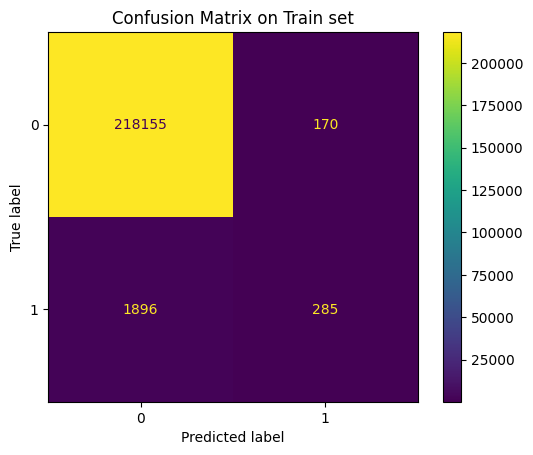

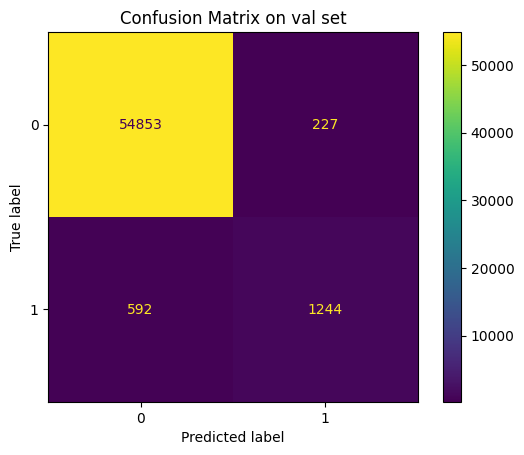

In [163]:
classifier = LogisticRegression() # 
classifier.fit(X_train, y_train)

#list_params = classifier.get_params()
#print(list_params)

reglog_4f_inf = model_scores('reglog_4f_inf', classifier, '4f_inf')
final_scoring= pd.concat([final_scoring,reglog_4f_inf]) 
#0.764936	0.755274 4feat_eng2
#0.760645	0.748939 4feat_ eng1 -> moins bon.
#final_scoring = reglog_full
#0.764936	0.755274 feat4 = the best
# 4f_inf sur le test set complet...: 0.216237	0.752344 Trop chelou : Ca veut dire que mon train foire ?!?!?
final_scoring

In [ ]:


for col in data.columns:
    X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, col)
    classifier = LogisticRegression() 
    classifier.fit(X_train, y_train)

    temp = model_scores(nom_variable('reglog_'+ col), classifier, name_dataset)
    final_scoring= pd.concat([final_scoring,temp])
    


reglog - Gridsearch

In [ ]:
# Paramètres reglog - Gridsearch

logreg = LogisticRegression()

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0]
}
reglog_opt = GridSearchCV(logreg, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
reglog_opt.fit(X_train, y_train)

reglog_gs = model_scores('reglog_gs', reglog_opt.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,reglog_gs])

reglog_gs.parametres[0]

#reglog_gs.parametres[0] 
''' 
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

'''


In [31]:
#reglog_gs.parametres # 'C': 0.1
reglog_gs.parametres[0]
#classification_report(y_train, y_train_pred)

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Boosting_reg_logistique
*AdaBoost (Boost s'entraine là où le modèle précédent s'est planté)


In [ ]:
### AdaBoost

logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
reglog_ada = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
reglog_ada_gs = GridSearchCV(reglog_ada, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
reglog_ada_gs.fit(X_train, y_train)

reglog_ada_gs = model_scores('reglog_ada_gs', reglog_ada_gs.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,reglog_ada_gs])
print(f'Adaboost_best_params = {reglog_ada_gs.parametres[0]}')

#Adaboost_best_params = {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__C': 0.5, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 1000, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=0.5, max_iter=1000), 'learning_rate': 1.0, 'n_estimators': 30, 'random_state': None}

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')



### Decision Tree
* BaggingClassifier ou Randeom Forest v
* XGboost XGBoost (prédit l'ereur du précédent) - que decision treses v
* Adaboost

{'base_estimator__max_depth': [4, 5, 8, 10], 'base_estimator__min_samples_leaf': [1, 2, 5, 10], 'base_estimator__min_samples_split': [2, 3, 4, 5], 'n_estimators': [5, 10, 30, 50]}


/home/melb/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/melb/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/melb/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/melb/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:717: FutureWarning:

Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.

/home/melb/.

classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7765
           1       0.91      0.70      0.79       235

    accuracy                           0.99      8000
   macro avg       0.95      0.85      0.89      8000
weighted avg       0.99      0.99      0.99      8000

classification report val
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1941
           1       0.91      0.66      0.76        59

    accuracy                           0.99      2000
   macro avg       0.95      0.83      0.88      2000
weighted avg       0.99      0.99      0.99      2000

matrices de confusion


/tmp/ipykernel_20627/3802164779.py:129: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_20627/3802164779.py:134: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



name_model  \
0  bag_tree_1000_feat_eng_gs   

                                               model    name_dataset  \
0  (DecisionTreeClassifier(max_depth=8, min_sampl...  10000_feat_eng   

  accuracy_train accuracy_val  f1_train    f1_val  
0       0.989125        0.988  0.790361  0.764706

name_model  \
0  bag_tree_1000_feat_eng_gs   

                                               model    name_dataset tn_val  \
0  (DecisionTreeClassifier(max_depth=8, min_sampl...  10000_feat_eng   1937   

  fp_val fn_val tp_val tn_train fp_train fn_train tp_train  
0      4     20     39     7749       16       71      164

name_model  \
0  bag_tree_1000_feat_eng_gs   

                                               model    name_dataset  \
0  (DecisionTreeClassifier(max_depth=8, min_sampl...  10000_feat_eng   

                                          parametres coefficients  
0  {'base_estimator': 'deprecated', 'bootstrap': ...           []

This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val']


NameError: name 'bag_tree_g3' is not defined

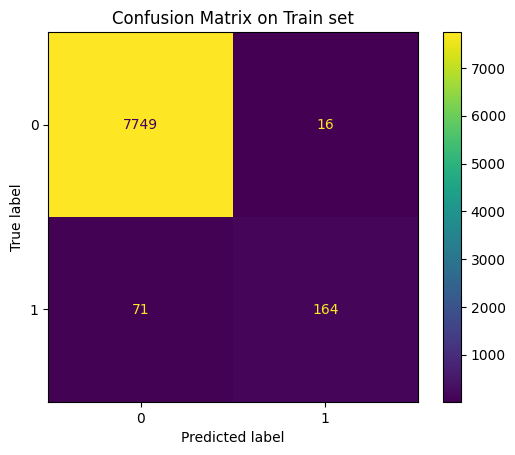

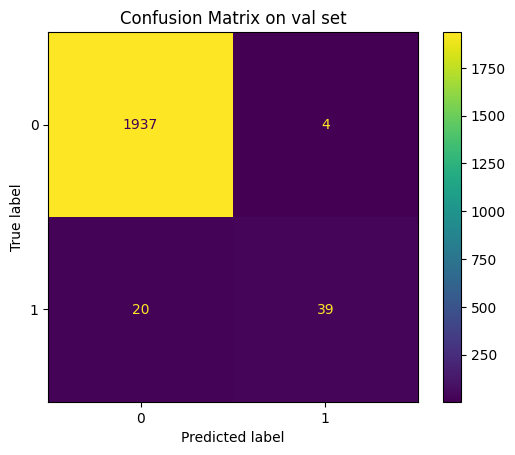

In [69]:
# Perform grid search
decision_tree = DecisionTreeClassifier()
bag_tree = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [4, 5, 8, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5, 10],
    'base_estimator__min_samples_split': [2, 3, 4, 5],
    'n_estimators': [5, 10, 30, 50]
}
print(params)
bag_tree_gs3 = GridSearchCV(bag_tree, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
bag_tree_gs3.fit(X_train, y_train)

bag_tree_eng_10000_gs = model_scores('bag_tree_1000_feat_eng_gs', bag_tree_gs3.best_estimator_, '10000_feat_eng')

final_scoring= pd.concat([final_scoring,bag_tree_eng_10000_gs])
print(f'bagtree_best_params = {bag_tree_gs3.parametres[0]}')

#1. 'estimator__criterion': 'gini', estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 4
# 2estimator__criterion': 'gini', 'estimator__max_depth': 5,'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'n_estimators': 3
# les 2 sont identiques....

#avec le feat_eng total : tree = 0.790361	0.764706
# params gridsearch =  'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2,  'n_estimators': 5,

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

In [56]:
final_scoring.loc[final_scoring['name_model']=='tree_4feng2', 'name_dataset']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [49]:


final_scoring

name_model  \
0                  reglog_full   
1               reglog_country   
2                   reglog_age   
3              reglog_new_user   
4                reglog_source   
5   reglog_total_pages_visited   
6             reglog_converted   
7                    reglog_gs   
8                reglog_ada_gs   
9                  bag_tree_gs   
10                 bag_tree_gs   
11              tree_simple_gs   
12           tree_simple_gini3   
13           tree_simple_gini8   
14           tree_simple_gs_3f   
15                 svc_1000_3f   
16                svc_10000_3f   
17             svc_gs_3f_10000   
18                 svc_full_3f   
19               xg_gs_full_3f   
20             ada_gs_10000_3f   
21             xg_gs2_10000_3f   
22        reglog_10000feat_eng   
23         tree_10000_feat_eng   
24   bag_tree_1000_feat_eng_gs   
25              reglog_4f_eng2   
26               reglog_4f_eng   
27                 tree_4feng1   
0                  tree_4feng1   

                                                model         name_dataset  \
0                                LogisticRegression()                 full   
1                                LogisticRegression()              country   
2                                LogisticRegression()                  age   
3                                LogisticRegression()             new_user   
4                                LogisticRegression()               source   
5                                LogisticRegression()  total_pages_visited   
6                                LogisticRegression()            converted   
7                           LogisticRegression(C=0.1)                 full   
8   AdaBoostClassifier(estimator=LogisticRegressio...                 full   
9   BaggingClassifier(estimator=DecisionTreeClassi...                 full   
10  BaggingClassifier(estimator=DecisionTreeClassi...                 full   
11  DecisionTreeClassifier(criterion='entropy', ma...                 full   
12                DecisionTreeClassifier(max_depth=3)                 full   
13                DecisionTreeClassifier(max_depth=8)                 full   
14  DecisionTreeClassifier(max_depth=5, min_sample...                3feat   
15                              SVC(probability=True)              1000_3f   
16                              SVC(probability=True)             10000_3f   
17  SVC(C=0.1, gamma=0.1, kernel='linear', probabi...             10000_3f   
18  SVC(C=0.1, gamma=0.1, kernel='linear', probabi...              full_3f   
19  XGBClassifier(base_score=None, booster=None, c...              full_3f   
20  AdaBoostClassifier(estimator=DecisionTreeClass...             10000_3f   
21  XGBClassifier(base_score=None, booster=None, c...                10000   
22                               LogisticRegression()       10000_feat_eng   
23                           DecisionTreeClassifier()       10000_feat_eng   
24  BaggingClassifier(estimator=DecisionTreeClassi...       10000_feat_eng   
25                               LogisticRegression()              4f_eng2   
26                               LogisticRegression()               4f_eng   
27                           DecisionTreeClassifier()              4f_eng2   
0                            DecisionTreeClassifier()              4f_eng2   

                                           parametres accuracy_train  \
0   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
1   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
2   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
3   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
4   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
5   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
6   {'C': 1.0, 'class_weight': None, 'dual': False...       0.986331   
7   {'C': 0.1, 'class_weight': None, 'dual': False...       0.986318   
8   {'algo

/home/melb/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/home/melb/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    218325
           1       0.66      0.18      0.29      2181

    accuracy                           0.99    220506
   macro avg       0.83      0.59      0.64    220506
weighted avg       0.99      0.99      0.99    220506

classification report val
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     55080
           1       0.84      0.36      0.50      1836

    accuracy                           0.98     56916
   macro avg       0.91      0.68      0.74     56916
weighted avg       0.97      0.98      0.97     56916

matrices de confusion


/tmp/ipykernel_13540/1506233637.py:129: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/home/melb/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/tmp/ipykernel_13540/1506233637.py:134: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



name_model                     model name_dataset accuracy_train  \
0  tree_4f_inf  DecisionTreeClassifier()       4f_inf       0.990998   

  accuracy_val f1_train    f1_val  
0     0.977107   0.2852  0.500575

name_model                     model name_dataset tn_val fp_val fn_val  \
0  tree_4f_inf  DecisionTreeClassifier()       4f_inf  54960    120   1183   

  tp_val tn_train fp_train fn_train tp_train  
0    653   218125      200     1785      396

name_model                     model name_dataset  \
0  tree_4f_inf  DecisionTreeClassifier()       4f_inf   

                                          parametres coefficients  
0  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...           []

This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val']


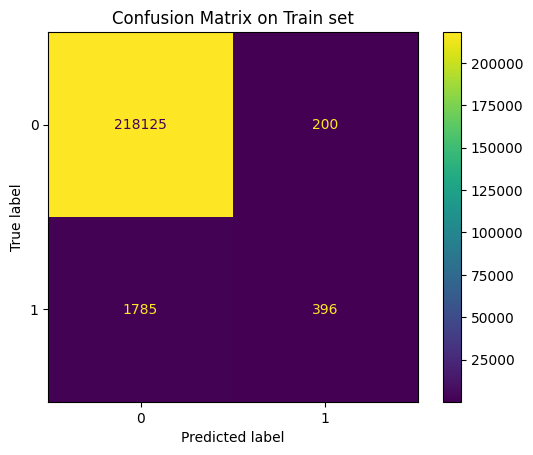

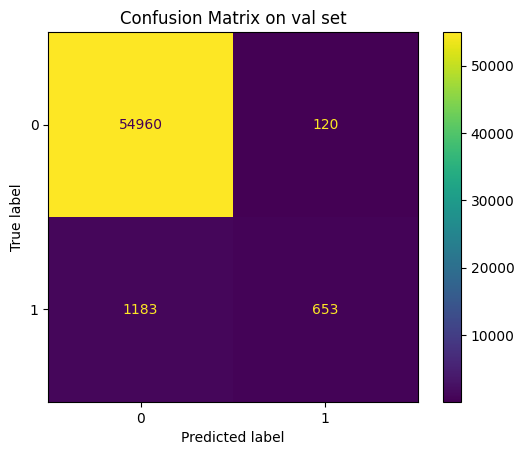

In [164]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
tree_4f_inf = model_scores('tree_4f_inf', decision_tree, '4f_inf')

final_scoring= pd.concat([final_scoring,tree_4f_inf])
# param classique : overfit à mort... Try avec gs...
#4feat_eng 1...0.781321	0.735632  overfitting
#4feat_eng 2...	0.781321 0.737001  overfitting _ idem
#4f - pas top, overfitting 0.781321	0.736619 
#4f_inf: 0.2852	0.500575

In [168]:


plt.figure(figsize=(80,200))
a = plot_tree(decision_tree, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(decision_tree)

Text(0.5, 1.0, 'DecisionTreeClassifier()')

In [ ]:
### A faire mais avec moins d'estimateurs peut être... pour trouver les bonnes valeurs au début... ou avec sample 1000_3f
decision_tree = DecisionTreeClassifier()
ada_tree = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [2, 5, 8, 10],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [10, 30, 50, 100]
}
ada_gs = GridSearchCV(ada_tree, param_grid = params, cv = 3)
ada_gs.fit(X_train, y_train)

ada_gs_10000_3f = model_scores('ada_gs_10000_3f', ada_gs.best_estimator_, '10000_3f')

# sur 10000 = pas top: 0.705128	0.701754, 2' - 'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2,'n_estimators': 10


final_scoring= pd.concat([final_scoring,ada_gs_10000_3f])

In [ ]:
### XGBoost: # que decision trees

### A refaire avec les nouveaux paramètres et full_3f

#reglog_xg = GradientBoostingClassifier(logistic_regression)

xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 5, 8], 
    'min_child_weight': [3, 10, 20], 
    'n_estimators': [30, 40, 50 ] 
}
print(params)
xg_gs2= GridSearchCV(xgboost, param_grid = params, cv = 3)
xg_gs2.fit(X_train, y_train)

xg_gs2_3f = model_scores('xg_gs2_3f', xg_gs2.best_estimator_, '3f')

final_scoring= pd.concat([final_scoring,xg_gs2_3f])
# 0.74479	0.729927- # 'max_depth': 2, 'min_child_weight': 3,'n_estimators': 50 - 15 '
#0.711111	0.672566 'max_depth': 5, 'min_child_weight': 10,  'n_estimators': 40

name_model         name_dataset  f1_train    f1_val
0                  reglog_full                 full  0.765451  0.755435
1               reglog_country              country  0.765451  0.755435
2                   reglog_age                  age  0.765451  0.755435
3              reglog_new_user             new_user  0.765451  0.755435
4                reglog_source               source  0.765451  0.755435
5   reglog_total_pages_visited  total_pages_visited  0.765451  0.755435
6             reglog_converted            converted  0.765451  0.755435
7                    reglog_gs                 full   0.76439  0.752421
8                reglog_ada_gs                 full  0.735693  0.721547
9                  bag_tree_gs                 full  0.729245  0.722616
10                 bag_tree_gs                 full  0.750412   0.73577
11              tree_simple_gs                 full  0.758111  0.737515
12           tree_simple_gini3                 full  0.729245  0.722616
13           tree_simple_gini8                 full  0.765369    0.7343
14           tree_simple_gs_3f                3feat   0.75147  0.735033
15                 svc_1000_3f              1000_3f  0.897959  0.444444
16                svc_10000_3f             10000_3f  0.720879  0.745763
17             svc_gs_3f_10000             10000_3f  0.725738  0.780488
18                 svc_full_3f              full_3f  0.738419   0.72626
19               xg_gs_full_3f              full_3f   0.74479  0.729927
20             ada_gs_10000_3f             10000_3f  0.705128  0.701754
21             xg_gs2_10000_3f                10000  0.711111  0.672566
22        reglog_10000feat_eng       10000_feat_eng       0.8  0.811321
23         tree_10000_feat_eng       10000_feat_eng  0.953229  0.648649
24   bag_tree_1000_feat_eng_gs       10000_feat_eng  0.790361  0.764706
25              reglog_4f_eng2              4f_eng2  0.764936  0.755274
26               reglog_4f_eng               4f_eng  0.760645  0.748939
27                 tree_4feng1              4f_eng2  0.781321  0.735632
28                 tree_4feng2              4f_eng2  0.781321  0.737001
0                    reglog_4f                   4f  0.764936  0.755274
0                      tree_4f                   4f  0.781321  0.736619

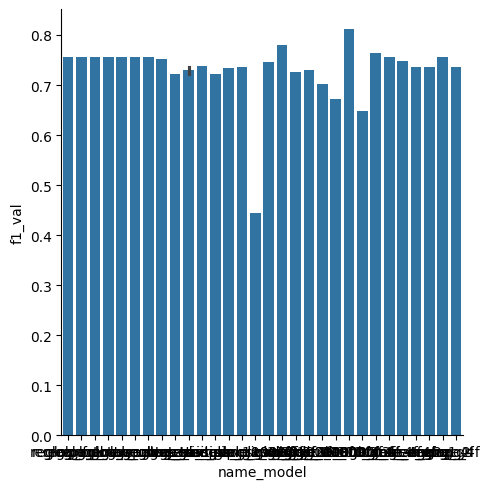

In [69]:

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')
final_scoring.loc[:, ['name_model', 'name_dataset', 'f1_train', 'f1_val']]

In [64]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False) 

In [ ]:

classification_report

from sklearn.tree import plot_tree

class_names = encoder.inverse_transform([0, 1, 2])

plt.figure(figsize=(20,20))
a = plot_tree(classifier_gini, 
              feature_names=X.columns, 
              class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)

## SVC classifier - gridsearch
J'ai dû commencer par tester sur des plus petits dataset de 1000 (overfitting), puis 10000 observations car sinon, ça prenait trop de temps pour le gs sur le dataset full.

J'ai fait tourner en normal, pour m'assurer que tout était ok,  puis gs 1000, puis gs 10000 puis j'ai pris les best params pour les faire tourner en svc simple sur l'ensemble du dataset. Resultats ok, mais pas top non plus.

In [ ]:
svc = SVC(kernel = 'linear', gamma = 0.1, C = 0.1, probability = True) #


svc.fit(X_train, y_train)
 
svc_full_3f = model_scores('svc_full_3f', svc, 'full_3f')

final_scoring= pd.concat([final_scoring,svc_full_3f])
#final_scoring.loc[final_scoring['name_model'] == '

#On 1000_3f = not enough 0. not ok. 0.89 on the train, only 0.44 on the val
#  10000_3f = 0.720879	0.745763
# full 13'  0.7384185613408862 0.7262604392205383]]

In [ ]:

# Perform grid search
svc = SVC(probability = True) # 'rbf'

# importer le final scoring
# Grid of values to be tested
params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}

svc_gs_m = GridSearchCV(svc, param_grid = params, cv = 3)
svc_gs_m .fit(X_train, y_train)

svc_3f_10000 = model_scores('svc_gs_3f_10000', svc_gs_m.best_estimator_, '10000_3f')

final_scoring= pd.concat([final_scoring,svc_3f_10000])
#final_scoring.loc[final_scoring['name_model'] == 'svc_gs', 'parametres'].values

# 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

# peut être fait avec DBScan, mais ce serait triché en ML Supervised
# moins bon en 3 feat
# sur 10000 _ 0.725738	0.780488_params : 
#{'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear'

## qu'est ce que ça veut dire : C 0.1 et gamma 0.1 sur ls données ? Car ce sont des valeurs faibles...

boosting svc, bagging svc


pis voting, stacking for all
puis sur dataset smaller... separer en 2...

Puis faire stacking arbre 2 leaves then le reste

voir avec DBScan su du feature engineering ? Garder le carré du total_pages _visited et le demi de age, new_user et country. 4f_eng. Retester sur le dataset complet.

[[0.7384185613408862 0.7262604392205383]]


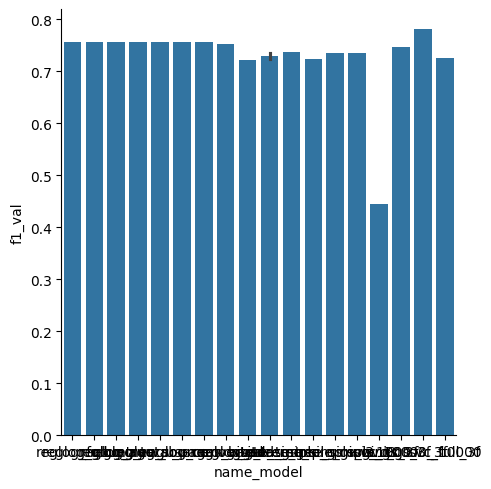

In [38]:
print(final_scoring.loc[final_scoring['name_model']=='svc_full_3f', ['f1_train', 'f1_val']].values)
sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')



# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

In [ ]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**